# 군집분석

한 기업이 해킹을 당해서 우리에게 도움을 요청했습니다! 다행스럽게도 그 기업의 포렌식 기술자들은 session time, location, wpm typing speed 등과 같은 해킹에 대한 귀중한 정보를 수집했습니다. 담당 포렌식 기술자와의 회의에서 듣기로는 해커들이 서버에 접속하는데에 사용한 각 세션의 메타 데이터들을 수집한 것이라고 합니다.

다음은 수집된 데이터입니다

- Session_Connection_Time : 세션이 지속된 시간(분)입니다.
- Bytes Transferred : 세션 중에 전송된 데이터 용량(MB)입니다.
- Kali_Trace_Used : 해커의 Kali Linux 사용 여부입니다.
- Servers_Corrupted : 공격으로 손상된 서버 수 입니다.
- Pages_Corrupted : 무단으로 접근한 페이지 수 입니다.
- Location : 공격이 시작된 위치입니다.(해커들이 VPN을 사용했기 때문에 아마 쓸모가 없을 것 같습니다.)
- WPM_Typing_Speed : 세션 로그를 기준으로 예상한 타이핑 속도입니다.

이 회사에서는 3명의 해커를 의심 중입니다. 2명의 해커는 어느정도 확신하고 있지만 세 번째 해커가 해킹에 연루되었는지 아직 확실하지 않습니다. 우리에게 의뢰한 부분은 이 부분입니다. 즉, 이번 해킹 사건에서 2명이 공격을 한 것인지 3명이 공격을 한 것인지 분석해달라고 합니다. 확실하지는 않지만 클러스터링으로 알아 볼 수 있을 것 같습니다.

마지막으로 한가지 알려드릴 중요한 사실은, 각 해커들의 공격횟수는 거의 동일합니다. 예를 들어, 총 공격 횟수가 100번 이었다면, 50건씩 2명이 공격을 했거나 3명이 약 33건씩 공격을 했다는 말입니다. 데이터는 hack_data.csv 파일로 전달해 드리겠습니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. 데이터 탐색 (EDA)

### 1) 기본 정보 확인

In [7]:
df = pd.read_csv("./data/hack_data.csv")

In [9]:
df.head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,Location,WPM_Typing_Speed
0,8.0,391.09,1,2.96,7.0,Slovenia,72.37
1,20.0,720.99,0,3.04,9.0,British Virgin Islands,69.08
2,31.0,356.32,1,3.71,8.0,Tokelau,70.58
3,2.0,228.08,1,2.48,8.0,Bolivia,70.80
4,20.0,408.50,0,3.57,8.0,Iraq,71.28


In [11]:
df.shape

(334, 7)

In [13]:
df.dtypes

Session_Connection_Time    float64
Bytes Transferred          float64
Kali_Trace_Used              int64
Servers_Corrupted          float64
Pages_Corrupted            float64
Location                    object
WPM_Typing_Speed           float64
dtype: object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Session_Connection_Time  334 non-null    float64
 1   Bytes Transferred        334 non-null    float64
 2   Kali_Trace_Used          334 non-null    int64  
 3   Servers_Corrupted        334 non-null    float64
 4   Pages_Corrupted          334 non-null    float64
 5   Location                 334 non-null    object 
 6   WPM_Typing_Speed         334 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 18.4+ KB


In [17]:
df.describe()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,30.008982,607.245269,0.511976,5.258503,10.838323,57.342395
std,14.088201,286.335932,0.500607,2.301907,3.063526,13.411063
min,1.000000,10.000000,0.000000,1.000000,6.000000,40.000000
25%,18.000000,372.200000,0.000000,3.122500,8.000000,44.127500
50%,31.000000,601.650000,1.000000,5.285000,10.500000,57.840000
75%,42.000000,843.702500,1.000000,7.400000,14.000000,70.577500
max,60.000000,1330.500000,1.000000,10.000000,15.000000,75.000000


### 2) 결측치 확인

In [20]:
df.isnull().sum()

Session_Connection_Time    0
Bytes Transferred          0
Kali_Trace_Used            0
Servers_Corrupted          0
Pages_Corrupted            0
Location                   0
WPM_Typing_Speed           0
dtype: int64

In [22]:
df.isnull().values.any()

False

### 3) 범주형 데이터 확인

In [25]:
df["Location"].value_counts()

Location
United States Virgin Islands    6
Guinea-Bissau                   5
Czech Republic                  5
Mauritania                      5
Trinidad and Tobago             4
                               ..
Austria                         1
Kuwait                          1
Samoa                           1
Mexico                          1
Canada                          1
Name: count, Length: 181, dtype: int64

In [27]:
df["Kali_Trace_Used"].value_counts()

Kali_Trace_Used
1    171
0    163
Name: count, dtype: int64

### 4) 변수 분포 시각화

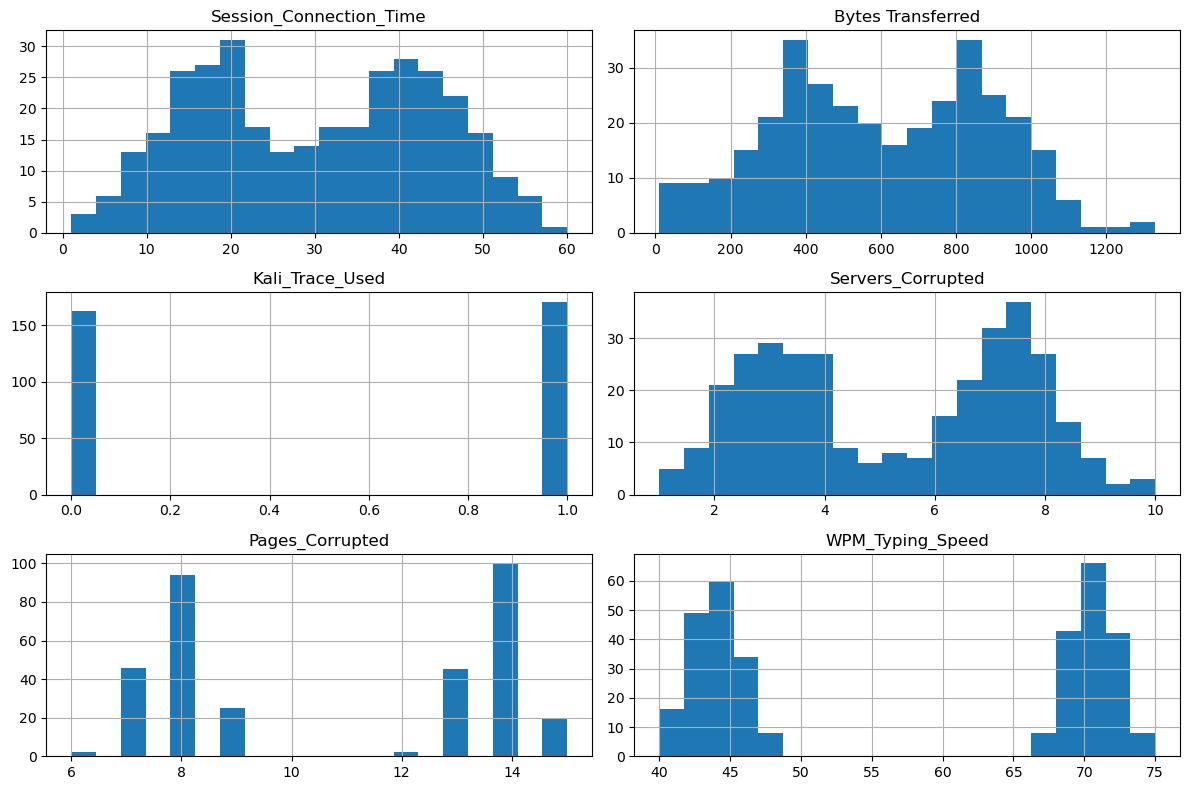

In [30]:
# 각 변수의 분포가 정규분포인지, 한쪽으로 치우쳐 있는지 파악
df.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()

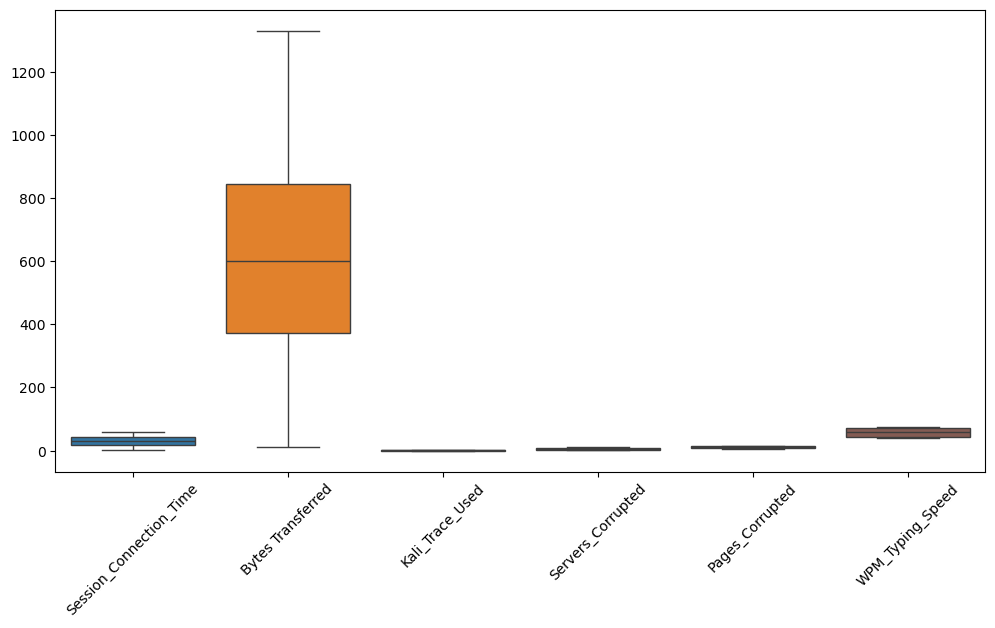

In [32]:
# 이상치(outlier) 확인
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=45)
plt.show()

- Bytes Transferreds를 제외한 나머지 변수들은 전반적으로 값의 분포가 좁고, 이상치도 많지 않아 안정적인 변수로 판단된다.
- Bytes Transferreds는 다른 변수들보다 값의 스케일이 크고 이상치가 존재하는 것으로 보여 스케일링이 필요하다.

# 2. 데이터 전처리

In [36]:
# Location 제거 (VPN 사용으로 의미 없음)
df = df.drop("Location", axis=1)

In [38]:
df.head()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
0,8.0,391.09,1,2.96,7.0,72.37
1,20.0,720.99,0,3.04,9.0,69.08
2,31.0,356.32,1,3.71,8.0,70.58
3,2.0,228.08,1,2.48,8.0,70.80
4,20.0,408.50,0,3.57,8.0,71.28


In [40]:
df.columns

Index(['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
       'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed'],
      dtype='object')

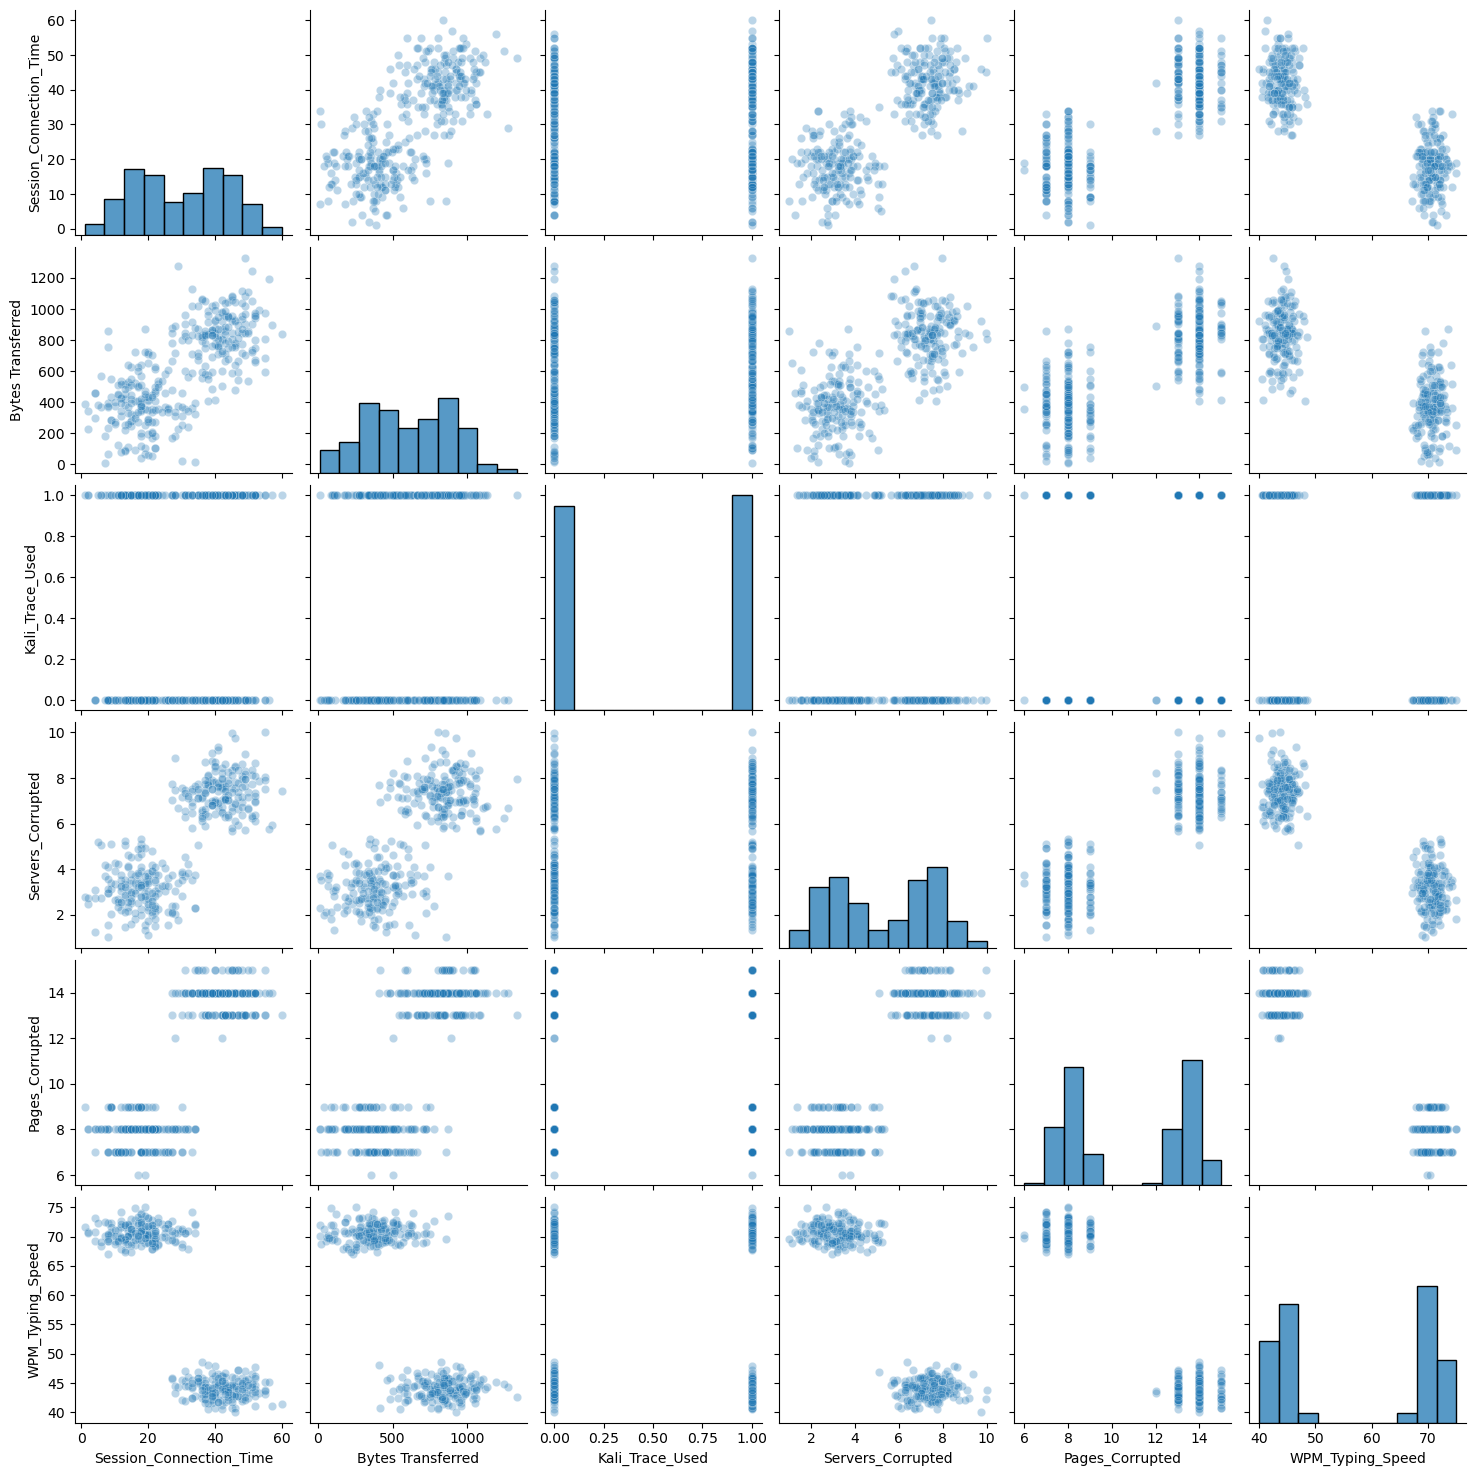

In [42]:
pairgrid = sns.pairplot(df, plot_kws = {"alpha" : 0.3 })

In [44]:
# 스케일링 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [46]:
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [48]:
scaled_df.describe()

,Session_Connection_Time,Bytes Transferred,Kali_Trace_Used,Servers_Corrupted,Pages_Corrupted,WPM_Typing_Speed
count,3.340000e+02,3.340000e+02,3.340000e+02,3.340000e+02,3.340000e+02,3.340000e+02
mean,-1.701899e-16,-1.701899e-16,1.595530e-17,-3.403798e-16,-8.509494e-17,-3.403798e-16
std,1.001500e+00,1.001500e+00,1.001500e+00,1.001500e+00,1.001500e+00,1.001500e+00
min,-2.062187e+00,-2.088950e+00,-1.024246e+00,-1.852765e+00,-1.581701e+00,-1.295081e+00
25%,-8.536931e-01,-8.221040e-01,-1.024246e+00,-9.293198e-01,-9.278791e-01,-9.868511e-01
50%,7.044937e-02,-1.957025e-02,9.763280e-01,1.152816e-02,-1.106016e-01,3.715972e-02
75%,8.524161e-01,8.270426e-01,9.763280e-01,9.317102e-01,1.033587e+00,9.883603e-01
max,2.131998e+00,2.529686e+00,9.763280e-01,2.062903e+00,1.360498e+00,1.318620e+00


# 3. 클러스터링 모델링

In [51]:
# inertia 값 저장
inertia = []

for k in range(1, 10):
    km = KMeans(n_clusters = k, random_state = 26)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

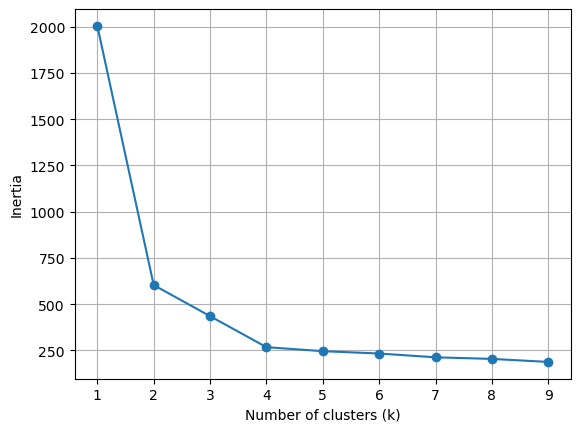

In [53]:
# Inertia 값 시각화
plt.figure()
plt.plot(range(1, 10), inertia, marker='o')

plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# 4. 클러스터링 비교

In [56]:
silhouette_scores = []

for k in range(2, 10):
    km = KMeans(n_clusters = k, random_state = 26)
    km.fit(scaled_data)
    labels = km.labels_
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

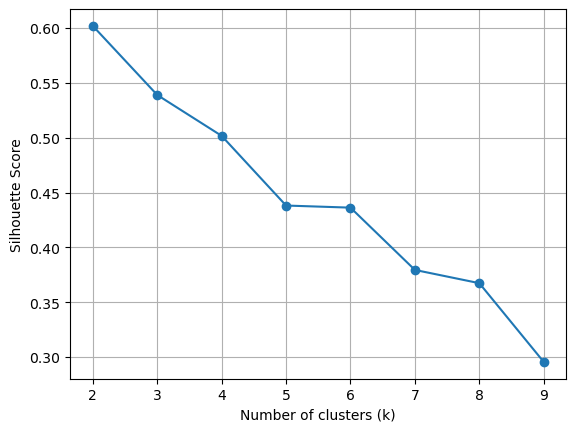

In [58]:
plt.figure()
plt.plot(range(2, 10), silhouette_scores, marker='o')

plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

## 1) 해커가 몇 명인지 찾기

In [61]:
# 실루엣 점수 비교 (k=2 vs k=3)
for k in [2, 3]:
    km = KMeans(n_clusters=k, random_state=26)
    labels = km.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    print(f"[k={k}] Silhouette Score: {score:.4f}")

[k=2] Silhouette Score: 0.6020
[k=3] Silhouette Score: 0.5390


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## 2) 각 해커마다 동일한 횟수로 공격 했다는 것 확인하기

In [64]:
# 최적 k로 클러스터링하여 label 분포 확인
km_final = KMeans(n_clusters=2, random_state=26)
final_labels = km_final.fit_predict(scaled_data)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [66]:
# 클러스터별 샘플 수
unique, counts = np.unique(final_labels, return_counts=True)
for i, count in zip(unique, counts):
    print(f"클러스터 {i}의 공격 수: {count}회")

클러스터 0의 공격 수: 167회
클러스터 1의 공격 수: 167회


In [68]:
# 표준편차로 '비슷한지' 확인
print(f"\n공격 횟수의 표준편차: {np.std(counts):.2f}")


공격 횟수의 표준편차: 0.00
